In [1]:
import keras
import numpy as np
import os
import matplotlib.pyplot as plt
from scipy import misc
import PIL
from keras.models import Model, Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
import pickle
%matplotlib inline

Using TensorFlow backend.
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [14]:
test_img_fnames = os.listdir('data/test')
train_img_fnames = os.listdir('data/train')
train_img_fnames = train_img_fnames[0:500]

# Load in the data
First we need to write a function to load into memory each of the images, and then resize them to (224, 224, 3). scipy.misc.imread and scipy.misc.imresize will be useful for this. You should also rescale the images so that they are on a scale of 0 to 1, meaning each pixel value should be between 0 and 1. This can be achieved by dividing by an appropriate constant.

In [15]:
def load_img(filename):
    # filename is name and path to img 
    img = misc.imread(name=filename)
    resized_img = misc.imresize(arr=img, size=(224,224,3))
    # rescale pixel values 
    return resized_img / 255
    

In [ ]:
test_imgs = [load_img(os.path.join('data/test', fname)) for fname in test_img_fnames]
test_imgs = np.stack(test_imgs)

In [16]:
train_imgs = [load_img(os.path.join('data/train', fname)) for fname in train_img_fnames]
train_imgs = np.stack(train_imgs)

In [8]:
with open('data/train_labels.pkl', 'rb') as f:
    train_labels = pickle.load(f)

# Load Pretrained VGG network
Now in order to generate the CNN featurizations of our images we need to load a pretrained network. Note that running this network will take a long time on CPU so you can feel free to skip this section and just load the featurizations I provided in the next section

In [ ]:
VGG16 = keras.applications.vgg16.VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

In [ ]:
VGG16.summary()

In [ ]:
featurized_training_data = VGG16.predict(train_imgs, verbose=1)

In [ ]:
featurized_test_data = VGG16.predict(test_imgs, verbose=1)

In [ ]:
# Save featurizations
import pickle
with open('featurized_train_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_training_data, f)
with open('featurized_test_imgs.pkl', 'wb') as f:
    pickle.dump(featurized_test_data, f)

# Load featurizations

In [3]:
import pickle
with open('featurized_train_imgs.pkl', 'rb') as f:
    featurized_training_data = pickle.load(f)
with open('featurized_test_imgs.pkl', 'rb') as f:
    featurized_test_data = pickle.load(f)

# Create you network
Now we need to create a network to take in the featurizations and output a label of dog or not dog. To do this you should use Keras' Sequential model. We will need to flatten our (7,7,512) feature input into a vector (HINT: lookup flatten in keras documentation) and then add a Dense layer with some number of neurons (play around with the number of neurons to improve your performance). Then finally we need a Dense layer with 1 neuron and a sigmoid activation to represent our label output. You might want to use more or less model.add calls than have been provided

In [4]:
model = Sequential()
model.add(Flatten(input_shape=(7,7,512)))
model.add(Dense(64, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                1605696   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,605,761
Trainable params: 1,605,761
Non-trainable params: 0
_________________________________________________________________


# Now we need to train the network
You need to compile the model first, and then use the fit function. You should use binary crossentropy as your loss.

In [6]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [9]:
model.fit(featurized_training_data, train_labels,epochs=5)

Epoch 1/5
10000/10000 [==============================] - 12s 1ms/step - loss: 0.4846 - acc: 0.8483
Epoch 2/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.2621 - acc: 0.9266
Epoch 3/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.1213 - acc: 0.9534
Epoch 4/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.0836 - acc: 0.9713
Epoch 5/5
10000/10000 [==============================] - 11s 1ms/step - loss: 0.0561 - acc: 0.9831


Now we need to predict labels for the test set and output it to file. Use keras predict for this. Remember that the predictions are real values between 0 and 1 and you should be outputting just 0 or 1, not a value between.

In [33]:
predictions = np.around(model.predict(featurized_test_data))

In [35]:
with open('test_labels.txt', 'w') as f:
    f.write("Id,Label\n")
    for i, val in enumerate(predictions):
        prediction = int(val[0])
        f.write(str(i))
        f.write(',')
        f.write(str(prediction))
        f.write('\n')

# Part 2

In [12]:
from sklearn.decomposition import PCA

Now we want to run PCA on our images and our featurizations to see the difference. To save time we will just run it on the first 500 images. Take the first 500 images and 500 featurizations and reshape them into shape (500, x).

In [17]:
# only pulled first 500 above 
original_imgs = train_imgs.reshape(500,150528)
featurized = featurized_training_data[0:500].reshape(500,25088)

Run PCA with 2 components on the original images

In [18]:
pca_orig = PCA(n_components=2)
# YOUR CODE HERE
pca_orig.fit(original_imgs)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Run PCA with 2 components on the featurizations

In [19]:
pca_featurized = PCA(n_components=2)
# YOUR CODE HERE
pca_featurized.fit(featurized)

PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

Project the original images and featurizations onto the 2 principal components. (HINT: look at the PCA.transform function)

In [20]:
projected_orig_imgs = pca_orig.transform(original_imgs)
projected_featurized = pca_featurized.transform(featurized)

Find the indices of the labels that are cats and the indices that are dogs. np.where will make this very easy

In [21]:
labels = train_labels[:500]
cat_inds = np.where(labels>0)
dog_inds = np.nonzero(labels<1)

Plot the PCA of the original images and the PCA of the featurization

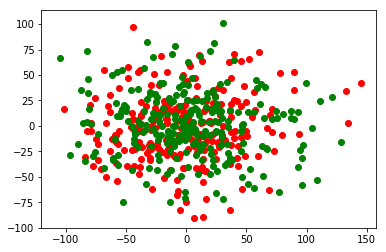

In [22]:
plt.scatter(projected_orig_imgs[cat_inds ,0], projected_orig_imgs[cat_inds, 1], c='red')
plt.scatter(projected_orig_imgs[dog_inds, 0], projected_orig_imgs[dog_inds, 1], c='green')

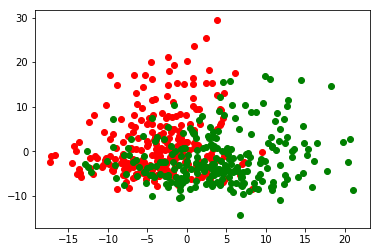

In [23]:
plt.scatter(projected_featurized[cat_inds ,0], projected_featurized[cat_inds, 1], c='red')
plt.scatter(projected_featurized[dog_inds, 0], projected_featurized[dog_inds, 1], c='green')

### Question 1 - Describe the differences you see between the two plots in terms of the clustering of the classes?: ###
    
    

The featurized data is more tightly clustered, with a clear distinction between the two classses. It would be possible to draw a boundary between the majority of data which is a dog and the majority which is a cat. Furthermore the data has less variance along the 2 principal components in each case. 

### Question 2 - Based on your answer to Question 1, desccribe why it is useful to featurize with a CNN before training a fully connnected model to classify the images: ###


Featurization makes the images easier to classify by reducing the noise in each image and extracting the salient points, in this case using binary cross entropy loss. It makes sense why this featurisation would result in higher performance, as each image is essentially modified to make it more cat or dog like based on the correct label 